# SBD on nuclear shell model

In [6]:
from src.hamiltonian_utils import FermiHubbardHamiltonian
from src.utils_quasiparticle_approximation import HardcoreBosonsBasis
from src.nuclear_physics_utils import get_twobody_nuclearshell_model,SingleParticleState
import numpy as np
import torch
from typing import Dict
import scipy
from src.qml_models import AdaptVQEFermiHubbard
from src.qml_utils.train import Fit
from src.qml_utils.utils import configuration
from scipy.sparse.linalg import eigsh,expm_multiply
from tqdm import trange
import matplotlib.pyplot as plt
from src.fermi_hubbard_library import FemionicBasis
import numpy as np
from typing import List, Dict
from scipy.linalg import expm
import scipy
from scipy.sparse.linalg import expm_multiply
from scipy.optimize import minimize
from scipy.sparse import coo_matrix
from scipy.sparse import lil_matrix
from scipy.optimize import minimize
from scipy import sparse
from src.hartree_fock_library import HFEnergyFunctional,HFEnergyFunctionalNuclear
import torch
import torch.nn as nn
import torch.optim as optim


file_name='data/cki'

SPS=SingleParticleState(file_name=file_name)

In [3]:
nparticles_a=4
nparticles_b=2 # Berillium

size_a=SPS.energies.shape[0]//2
size_b=SPS.energies.shape[0]//2

title=r'$^{10}$Be'

Exact solution:

In [4]:

# Compute the J^2 value
#J2Class=J2operator(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,single_particle_states=SPS.state_encoding,j_square_filename=file_name+'_j2',symmetries=[SPS.total_M_zero])

#Quadrupole Operator


# compute the NSM Hamiltonian
NSMHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,symmetries=[SPS.total_M_zero])
print('size=',size_a+size_b,size_b)
NSMHamiltonian.get_external_potential(external_potential=SPS.energies[:size_a+size_b])
if file_name=='data/cki':
    twobody_matrix,energies=get_twobody_nuclearshell_model(file_name=file_name)

    NSMHamiltonian.get_twobody_interaction(twobody_dict=twobody_matrix)
else:
    NSMHamiltonian.twobody_operator=scipy.sparse.load_npz(f'data/nuclear_twobody_matrix/usdb_{nparticles_a}_{nparticles_b}.npz')
NSMHamiltonian.get_hamiltonian()

####
H = NSMHamiltonian.hamiltonian # hamiltonian as sparse matrix
basis = NSMHamiltonian.basis # basis
###

egs,psi0=NSMHamiltonian.get_spectrum(n_states=1) # exact solution, later to confront
psi0 = psi0.reshape(-1)

print(egs)

print('total_m=',SPS.compute_m_exp_value(psi=psi0,basis=NSMHamiltonian.basis))
#print('j_value=',J2Class.j_value(psi0))
print('dimension=',NSMHamiltonian.hamiltonian.shape[0])

size= 12 6
Computing the matrix, pls wait... (u_u) 



  0%|          | 0/12 [00:00<?, ?it/s]

100%|██████████| 12/12 [00:01<00:00,  8.25it/s]
1424it [00:03, 417.07it/s]


[-39.4534158]
total_m= 5.605325231750058e-17
dimension= 51


Hartree-Fock

In [7]:
#model=HFEnergyFunctional(h_vec=torch.tensor(SPS.energies),V_dict=twobody_matrix,num_particles=nparticles_a+nparticles_b)
model=HFEnergyFunctionalNuclear(h_vec=torch.tensor(SPS.energies,dtype=torch.double),V_dict=twobody_matrix,num_neutrons=nparticles_a,num_protons=nparticles_b,neutron_indices=0,proton_indices=size_a)

optimizer = optim.Adam(model.parameters(), lr=0.01)

num_steps = 600
for step in range(num_steps):
    optimizer.zero_grad()
    energy = model()  # calls forward()
    energy.backward()
    optimizer.step()

    if step % 20 == 0 or step == num_steps - 1:
        print(f"Step {step:4d} | Energy = {energy.item():.6f}")

/home/ecosta/miniconda3/envs/annealing-nsm-env/lib/python3.10/site-packages/torch/autograd/graph.py:829: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11060). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step    0 | Energy = -22.818373
Step   20 | Energy = -27.990202
Step   40 | Energy = -30.991363
Step   60 | Energy = -32.359893
Step   80 | Energy = -32.643607
Step  100 | Energy = -33.020408
Step  120 | Energy = -33.496099
Step  140 | Energy = -33.875295
Step  160 | Energy = -34.071401
Step  180 | Energy = -34.141339
Step  200 | Energy = -34.159522
Step  220 | Energy = -34.163054
Step  240 | Energy = -34.163546
Step  260 | Energy = -34.163589
Step  280 | Energy = -34.163590
Step  300 | Energy = -34.163590
Step  320 | Energy = -34.163590
Step  340 | Energy = -34.163590
Step  360 | Energy = -34.163590
Step  380 | Energy = -34.163590
Step  400 | Energy = -34.163590
Step  420 | Energy = -34.163590
Step  440 | Energy = -34.163590
Step  460 | Energy = -34.163590
Step  480 | Energy = -34.163590
Step  500 | Energy = -34.163590
Step  520 | Energy = -34.163590
Step  540 | Energy = -34.163590
Step  560 | Energy = -34.163590
Step  580 | Energy = -34.163590
Step  599 | Energy = -34.163590


In [8]:
def slater_determinants_combined(C_n, C_p, fock_basis):
    """
    C_n: [M_half, N_n]  -- neutron orbitals
    C_p: [M_half, N_p]  -- proton orbitals
    fock_basis: [F, M]  -- full occupation basis (neutrons + protons)

    Returns:
        psi: [F]  -- Slater determinant amplitudes
    """
    F, M = fock_basis.shape
    M_half = M // 2
    N_n = C_n.shape[1]
    N_p = C_p.shape[1]

    psi = torch.zeros(F, dtype=C_n.dtype)

    for i in range(F):
        occ = fock_basis[i]  # [M]

        occ_n = torch.nonzero(occ[:M_half]).squeeze()
        occ_p = torch.nonzero(occ[M_half:]).squeeze()+M_half

        Cn_sub = C_n[occ_n, :]  # shape [N_n, N_n]
        Cp_sub = C_p[occ_p, :]  # shape [N_p, N_p]

        if Cn_sub.shape[0] != N_n or Cp_sub.shape[0] != N_p:
            # Skip invalid configurations (e.g., wrong number of particles)
            continue

        det_n = torch.det(Cn_sub)
        det_p = torch.det(Cp_sub)
        psi[i] = det_n * det_p


    return psi  # [F]

def slater_determinants_only_neutrons(C_n, fock_basis):
    """
    C_n: [M_half, N_n]  -- neutron orbitals
    C_p: [M_half, N_p]  -- proton orbitals
    fock_basis: [F, M]  -- full occupation basis (neutrons + protons)

    Returns:
        psi: [F]  -- Slater determinant amplitudes
    """
    F, M = fock_basis.shape
    M_half = M // 2
    N_n = C_n.shape[1]


    psi = torch.zeros(F, dtype=C_n.dtype)

    for i in range(F):
        occ = fock_basis[i]  # [M]

        occ_n = torch.nonzero(occ[:M_half]).squeeze()


        Cn_sub = C_n[occ_n, :]  # shape [N_n, N_n]




        det_n = torch.det(Cn_sub)

        psi[i] = det_n 

    return psi  # [F]


In [9]:

#psi_hf=slater_determinants_only_neutrons(model.C_n, torch.tensor(NSMHamiltonian.basis))
psi_hf=slater_determinants_combined(model.C_n, model.C_p, torch.tensor(NSMHamiltonian.basis))

psi_hf=psi_hf.detach().numpy()

psi_hf=psi_hf/np.linalg.norm(psi_hf)

In [ ]:


print(psi_hf.conjugate() @ NSMHamiltonian.hamiltonian @ psi_hf)

print('fidelity=',psi0[:].conjugate().dot(psi_hf)*np.conjugate(psi0[:].conjugate().dot(psi_hf)))

-36.57502219874993
fidelity= 0.485089147189017


Voglio una classe Nuclear shell model sqd ansatz (trova un nome migliore hahah), i suoi parametri sono H e la base oppure numero particelle e per il resto fa automatico. Voglio i seguenti metodi:
- Inizializzazione stato con lo stato della base con minore energia
- Creazione operator pool
- compute state con produttoria delle unitarie ottenute esponenziando la somma degli operatori nell'operator pool sommati con il loro complesso coniugato fatta con scipy exp multiply applicato a stato precedente (se prima iter a quello dell'inizializzazione)
- fare SQD con quello stato e stimare energia con SQD

In secondo momento sarà da aggiungere anche minimizzazione energia!!!


In [ ]:
import itertools
from scipy.optimize import dual_annealing

def genera_ij(N): # crea lista indici (0,1),(0,2),..,(0,N-1),(1,2),....,(N-2,N-1) con N input
    return [(i, j) for i in range(N) for j in range(i + 1, N)]


def genera_i1i2j1j2(N):
    """
    Restituisce una lista di tuple (i1, i2, j1, j2) con valori unici tra 0 e N-1
    ed evita ripetizioni causate da permutazioni interne.
    """
    result = set()
    indices = range(N)

    for comb in itertools.combinations(indices, 4):  # scegli 4 indici distinti
        for split in itertools.combinations(comb, 2):  # scegli 2 per il primo "pair"
            # ottieni i1, i2 dal primo gruppo; j1, j2 dagli altri due
            i1, i2 = sorted(split)
            rest = [x for x in comb if x not in (i1, i2)]
            j1, j2 = sorted(rest)

            # crea una tupla canonica: (i1, i2, j1, j2)
            tup = (i1, i2, j1, j2)
            result.add(tup)

    return sorted(result)


class NSM_SQD_circuit_ansatz:

    def __init__(self, file_name = 'data/cki', nparticles_a=4, nparticles_b=2,M=None, samples = 20, batches =100, train_steps = 10,num_parameters=30):
        self.M = M
        if self.M == 0:
            # compute the NSM Hamiltonian and the basis
            self.NSMHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,symmetries=[SPS.total_M_zero])
            print('size=',size_a+size_b,size_b)
            self.NSMHamiltonian.get_external_potential(external_potential=SPS.energies[:size_a+size_b])
            if file_name=='data/cki':
                twobody_matrix,energies=get_twobody_nuclearshell_model(file_name=file_name)
                self.twobody_matrix=twobody_matrix
                self.NSMHamiltonian.get_twobody_interaction(twobody_dict=twobody_matrix)
            else:
                self.NSMHamiltonian.twobody_operator=scipy.sparse.load_npz(f'data/nuclear_twobody_matrix/usdb_{nparticles_a}_{nparticles_b}.npz')
            self.NSMHamiltonian.get_hamiltonian()

        else:
            # compute the NSM Hamiltonian and the basis
            self.NSMHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,symmetries=[])
            print('size=',size_a+size_b,size_b)
            self.NSMHamiltonian.get_external_potential(external_potential=SPS.energies[:size_a+size_b])
            if file_name=='data/cki':
                twobody_matrix,energies=get_twobody_nuclearshell_model(file_name=file_name)
                self.twobody_matrix=twobody_matrix
                self.NSMHamiltonian.get_twobody_interaction(twobody_dict=twobody_matrix)
            else:
                self.NSMHamiltonian.twobody_operator=scipy.sparse.load_npz(f'data/nuclear_twobody_matrix/usdb_{nparticles_a}_{nparticles_b}.npz')
            self.NSMHamiltonian.get_hamiltonian()

        ####
        self.H = NSMHamiltonian.hamiltonian # hamiltonian as sparse matrix
        self.basis = NSMHamiltonian.basis # basis
        ###

        self.l = len(self.basis[0]) # lunghezza un elemento base
        self.operator_pool = {} # op pool as dict where key is (i,j)
        self.operator_pool_list = [] # op pool as list 
        self.psi = np.zeros(len(self.basis))
        self.E = 0.

        self.seed = 1024

        self.samples = samples # number of samples for sqd energy estimation
        self.batches = batches # different batches for sqd to make an average of the energy
        self.train_steps = train_steps # steps in optimization
        self.num_parameters = num_parameters # number of parameters in the ansatz

    def initialize_state_v1(self): # ref state is the element of the basis with the minimum energy
        self.psi = np.zeros(len(self.basis))  
        diag = self.H.diagonal()
        min_state_idx = diag.argmin()
        self.psi[min_state_idx] = 1. 
        self.psi /= np.linalg.norm(self.psi)
        self.E = diag.min()
        return None

    def initialize_state_v2(self,ns): # ref state is the element of the basis with the minimum energy
        self.psi = np.zeros(len(self.basis)) 
        diag = self.H.diagonal()
        min_indices = np.argsort(diag)[:ns]
        self.psi[min_indices] = 1. / np.sqrt(ns)
        self.psi /= np.linalg.norm(self.psi)
        self.E = diag[min_indices].mean()
        return None

    def initialize_state_v3(self,psi_hf): # ref state is the element of the basis with the minimum energy
        self.psi = psi_hf
        self.E = self.psi.transpose().conj() @ self.H @ self.psi
        return None




    def miquel_constrainer(self,idxs:List[int]):
        
        if SPS.projection_conservation(idxs=idxs):
            if HardcoreBosonsBasis(self.basis).charge_computation(initial_indices=idxs[:2],final_indices=idxs[2:]):
                op=HardcoreBosonsBasis(self.basis).adag_adag_a_a_matrix(idxs[0],idxs[1],idxs[2],idxs[3])
                diag_op = sparse.diags(op.diagonal())

                non_diag_op =np.abs( op - diag_op)
                if not(np.isclose(non_diag_op.sum(),0.)):
                    condition=True
                else:
                    condition=False
            
            else:
                condition=False
        else:
            condition=False
                    
        return condition


    def miquel_constrainer_2(self,idxs:List[int]):
        _,_,j0,_,_,tz0=SPS.state_encoding[idxs[0]]
        _,_,j1,_,_,tz1=SPS.state_encoding[idxs[1]]
        _,_,j2,_,_,tz2=SPS.state_encoding[idxs[2]]
        _,_,j3,_,_,tz3=SPS.state_encoding[idxs[3]]
        
        j_tot_i = np.arange(start=int(np.abs(j0 - j1)), stop=int(j0 + j1) + 1)  # Include j0 + j1
        j_tot_f = np.arange(start=int(np.abs(j2 - j3)), stop=int(j2 + j3) + 1)  # Include j2 + j3
        #print(j_tot_i,j0,j1)
        if tz0==tz1:
            if j0==j1:
                j_tot_i=[j for j in j_tot_i if j % 2==0 ]
                #print('i=',j_tot_i,j0,j1)
            if j2==j3:
                j_tot_f=[j for j in j_tot_f if j % 2==0 ]
                #print('f=',j_tot_f,j2,j3,'\n')
            if set(j_tot_i) & set(j_tot_f):
                
                
                condition=True
            else:
                
                condition=False

        else:

        
            if set(j_tot_i) & set(j_tot_f):
                condition=True
            else:

                condition=False


                
        return condition
    
    def miquel_constrainer_3(self,idxs:List[int]):
        condition=False
        p=np.random.uniform(0,1)
        if SPS.projection_conservation(idxs=idxs):
            if p<1:
                condition=True
                    
        return condition


    def create_operator_pool_twobody_symmetry(self): # nella pool two body op che rispettano i miquel constraints
        self.operator_pool:Dict={}
        self.operator_pool = self.NSMHamiltonian.set_operator_pool(operator_pool=self.operator_pool,conditions=[SPS.projection_conservation,self.miquel_constrainer_2,self.miquel_constrainer,self.miquel_constrainer_3],nbody='two')
        vs, ops, keys = [], [], []
        for key, op in self.operator_pool.items():
            if key in self.twobody_matrix:
                vs.append(self.twobody_matrix[key])
                ops.append(op)
                keys.append(key)

        vs = np.abs(np.array(vs))
        selection = np.argsort(vs)[-self.num_parameters:][::-1]
        selected_vs = vs[selection]


        new_operator_pool = {keys[idx]: ops[idx] for idx in selection}
        self.operator_pool = new_operator_pool
        self.operator_pool_list = list(self.operator_pool.values())
        np.random.seed(self.seed) 
        self.weights = np.zeros(len(self.operator_pool))#np.random.uniform(-1.3, 1.3, size=len(self.operator_pool))
        return None

    def forward(self, weights): # compute psi
        psi = self.psi.copy()
        if self.weights is not(None):
            
            for i, w in enumerate(weights):
                # print(np.conj(expm(self.weights[i] * op).T) @ expm(self.weights[i] * op))
                psi = scipy.sparse.linalg.expm_multiply( (0. + 1j) * w * self.operator_pool_list[i],psi) 
                psi = psi / np.linalg.norm(psi)

        return psi

    def SQD(self, weights): #output è energia stimata con SQD (compute energy functional)
        psi = self.forward(weights)
        prob = (np.conjugate(psi) * psi).real # .real needed to change data type from complex to float
        Ham = self.H.copy()
        np.random.seed(self.seed) # seed con cui calcolo il vettore random i cui elementi sono i seed dei diversi batch
        seeds = np.random.randint(1, 30002, size=self.batches)
        e = np.zeros(self.batches)
        self.psi_batches=np.zeros((self.batches,self.psi.shape[0]))
        for k,s in enumerate(seeds):
            np.random.seed(s)
            #print('non zero prob=',np.nonzero(prob)[0].shape[0])

            
            if np.nonzero(prob)[0].shape[0]<self.samples:
                selection = np.random.choice(len(self.basis), size=np.nonzero(prob)[0].shape[0], replace=False, p=prob)

            else:
                
                selection = np.random.choice(len(self.basis), size=self.samples, replace=False, p=prob)

            if len(selection)!=1:    
                effective_hamiltonian=  Ham.tocsr()[selection,:][:,selection]

                value,eighvec = eigsh(effective_hamiltonian, k=1, which="SA", maxiter=int(1E6), ) # Diagonalization of reduced H
                e[k]=value[0]
                self.psi_batches[k,selection]=eighvec[:,0]
            
            else:
                e[k]=Ham[selection[0],selection[0]]
            
        self.variance=np.std(e)
        return np.average(e)
    
    def cobyla_callback(self, x):
        # Callback function for COBYLA (optional, for printing intermediate results)
        print(f"Current COBYLA weights: {np.linalg.norm(x)}, SQD: {self.SQD(x)} Variance energy {self.variance}")

    def optimization(self):
            initial_guess = self.weights if i == 0 else self.weights # Use current weights as initial guess
            bounds = [(-2.0, 2.0)] * len(self.weights)
            res = dual_annealing(
                self.SQD,
                bounds=bounds,
                maxiter=100,      # ⬅️ limit outer loop iterations
                maxfun=5000,     # ⬅️ cap total function evaluations
                callback=self.annealing_callback,
            )
            self.weights = res.x
            
            
        for i in range(self.train_steps):
            # COBYLA optimization

            res2 = minimize(self.SQD, x0=self.weights, method='COBYLA', options={'disp':True},callback=self.cobyla_callback)

            self.weights = res2.x  # update weights
            self.E = self.SQD(self.weights)
            self.psi = self.forward(self.weights)

            print(f'\n--- Training Step {i+1} ---')
            print('Optimization Success =', res2.success)
            print('Energy (SQD) =', self.E)
            print('Message =', res2.message)
            print('Current weights =', self.weights)
            print('Number of function evaluations =', res2.nfev)


    def annealing_callback(self,x, f, context,*args):
        print(f"Step context: {context} | Energy: {f} \n")
        self.weights=x.copy()
        #print(f"Weights: {x}\n")
        

In [51]:
m = NSM_SQD_circuit_ansatz(M=0,samples=30, train_steps=10,num_parameters=20,batches=100) # nb da samples = 48 da e esatta se si parte da prob esatta
m.initialize_state_v3(psi_hf)

m.create_operator_pool_twobody_symmetry()

size= 12 6
Computing the matrix, pls wait... (u_u) 



100%|██████████| 12/12 [00:01<00:00,  8.51it/s]
1424it [00:03, 427.66it/s]


In [52]:
print(len(m.operator_pool))
print(m.weights)

20
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [53]:
print(m.forward(m.weights))

m.psi
m.E

[-0.61843343+0.j  0.21870923+0.j  0.0869069 +0.j  0.0869069 +0.j
 -0.15495085+0.j  0.01553308+0.j -0.01738517+0.j -0.05975021+0.j
  0.03781027+0.j  0.02182977+0.j -0.1034904 +0.j  0.06548931+0.j
  0.03781027+0.j  0.37456316+0.j -0.13246441+0.j -0.05263642+0.j
 -0.05263642+0.j  0.09384822+0.j -0.03419246+0.j  0.0382694 +0.j
  0.37456316+0.j -0.13246441+0.j -0.05263642+0.j -0.05263642+0.j
  0.09384822+0.j -0.1034904 +0.j  0.03781027+0.j  0.06548931+0.j
 -0.03009041+0.j  0.01904138+0.j  0.01099355+0.j  0.32757082+0.j
 -0.11584555+0.j -0.04603271+0.j -0.04603271+0.j  0.08207411+0.j
 -0.05975021+0.j  0.02182977+0.j  0.03781027+0.j  0.01553308+0.j
 -0.01738517+0.j -0.0357177 +0.j  0.01263158+0.j  0.00501932+0.j
  0.00501932+0.j -0.00894921+0.j -0.03009041+0.j  0.01099355+0.j
  0.01904138+0.j -0.03419246+0.j  0.0382694 +0.j]


np.float64(-36.57502219874993)

In [54]:
m.SQD(np.zeros(m.weights.shape))

np.float64(-37.285632654167)

In [ ]:
m.optimization()

[2.93982132e-02 1.53841300e-02 2.16543065e-04 3.96286856e-05
 1.36327718e-01 4.34484769e-02 7.70139252e-02 2.05141204e-03
 8.97625776e-12 2.35156700e-04 8.26152593e-11 2.04229621e-03
 1.09288201e-11 2.88424103e-03 2.44946710e-03 5.58232370e-08
 5.39585939e-03 5.28320746e-03 6.21353459e-03 3.78377602e-04
 1.29337487e-02 6.91600526e-03 3.04325258e-03 2.60546955e-05
 5.54306757e-02 9.65034035e-11 1.09288201e-11 1.39218979e-02
 6.90147978e-03 1.54470941e-11 2.70591132e-07 7.39967127e-03
 4.69894078e-03 1.74181203e-04 3.21533961e-03 1.23370874e-02
 1.87621068e-06 1.06517447e-07 1.07059357e-11 2.33107796e-01
 2.57846983e-01 9.33933759e-05 4.95061494e-03 2.01783871e-05
 3.56521478e-07 1.49413711e-02 8.12475137e-05 1.71947188e-09
 3.28862787e-12 2.17394708e-02 1.14557547e-02]
[ 1.08629183e+00 -4.96801883e-01  1.99681433e+00  1.00979672e+00
  9.74243253e-01  8.07449668e-01 -8.28284103e-02  9.09900271e-02
  6.45410131e-02  4.17860840e-01  2.33652126e-01  3.39137992e-02
 -3.18607147e-02  9.522481

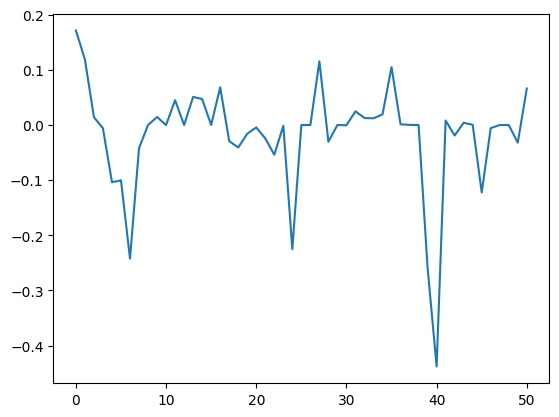

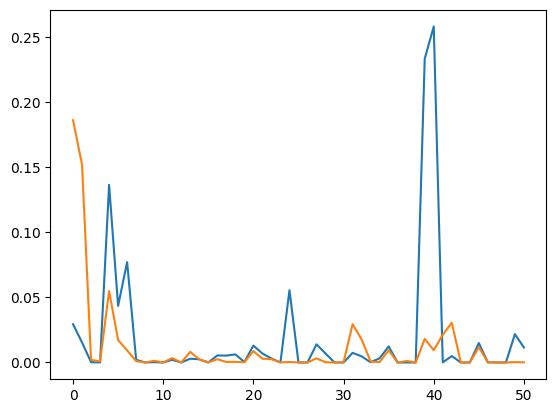

In [58]:
probb = (np.conjugate(m.forward(m.weights)) * m.forward(m.weights)).real

print(probb)
print(m.weights)
plt.plot(m.forward(m.weights))
plt.show()
prob_samples=np.average((np.conjugate(m.psi_batches) * m.psi_batches),axis=0).real

plt.plot(probb)
plt.plot(prob_samples)

plt.show()

[ 1.08629183e+00 -4.96801883e-01  1.99681433e+00  1.00979672e+00
  9.74243253e-01  8.07449668e-01 -8.28284103e-02  9.09900271e-02
  6.45410131e-02  4.17860840e-01  2.33652126e-01  3.39137992e-02
 -3.18607147e-02  9.52248105e-04  6.09699871e-01  2.39908599e-02
  1.98014406e+00  9.95903267e-01  1.84643116e-01 -2.27033640e-01]


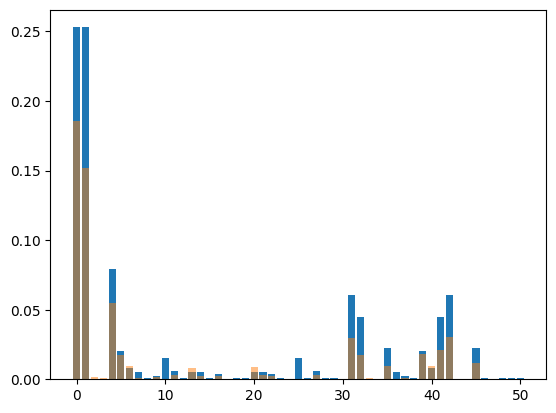

In [64]:
plt.bar(np.arange(psi0.shape[0]),(np.conjugate(psi0) * psi0).real)

#plt.bar(np.arange(m.psi.shape[0]),probb,alpha=0.5)

plt.bar(np.arange(m.psi.shape[0]),prob_samples,alpha=0.5)

print(m.weights)

In [77]:
fidelities=np.conjugate(np.einsum('ai,i->a',m.psi_batches,psi0))*np.einsum('ai,i->a',m.psi_batches,psi0)
print(np.average(fidelities))

for i in range(71,100):
    print(m.psi_batches[i].dot(NSMHamiltonian.hamiltonian.dot(m.psi_batches[i])))
    fidelities=np.conjugate(np.einsum('i,i->',m.psi_batches[i],psi0))*np.einsum('i,i->',m.psi_batches[i],psi0)
    print(np.average(fidelities))


0.5010589847028523
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
